In [3]:
%%markdown
# Implementation of LSTM for the nowcasting data

# Implementation of LSTM for the nowcasting data

In [161]:
import azureml
from azureml.core import Workspace, Run
print("Azure ML SDK Version: ", azureml.core.VERSION)

#!pip3 install --upgrade tensorflow

import tensorflow as tf
import pandas as pd
import keras
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import numpy
print(tf.__version__)
print(keras.__version__)




Azure ML SDK Version:  0.1.65
1.11.0
2.0.8


In [5]:
ws = Workspace(subscription_id = '25217860-50f5-4312-87a7-1bfab0105444' , resource_group = 'code.fun.do', workspace_name = 'codefundo', auth=None, _location='southeastasia', _disable_service_check=False)

Performing interactive authentication. Please follow the instructions on the terminal.


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FMMC99JYS to authenticate.


Interactive authentication successfully completed.


In [6]:
from azureml.core import Experiment

In [7]:
exp = Experiment(workspace = ws, name = 'Nowcast_forecast')

In [8]:
from azureml.core.compute import ComputeTarget, BatchAiCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
batchai_cluster_name = "traincluster"

try:
    # look for the existing cluster by name
    compute_target = ComputeTarget(workspace=ws, name=batchai_cluster_name)
    if type(compute_target) is BatchAiCompute:
        print('found compute target {}, just use it.'.format(batchai_cluster_name))
    else:
        print('{} exists but it is not a Batch AI cluster. Please choose a different name.'.format(batchai_cluster_name))
except ComputeTargetException:
    print('creating a new compute target...')
    compute_config = BatchAiCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", # small CPU-based VM
                                                                #vm_priority='lowpriority', # optional
                                                                autoscale_enabled=True,
                                                                cluster_min_nodes=0, 
                                                                cluster_max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, batchai_cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

    # Use the 'status' property to get a detailed status for the current cluster. 
    print(compute_target.status.serialize())

found compute target traincluster, just use it.


In [9]:
series = pd.read_csv("nowacst.csv")

In [10]:
series.head()

,0,14
0,1,63
1,2,6
2,3,139
3,4,7
4,5,29


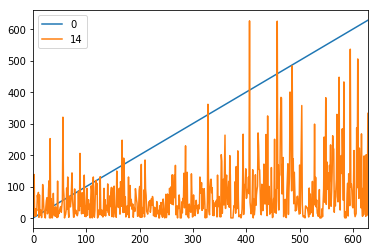

In [11]:
series.plot()

In [137]:
series.shape

(629, 2)

In [149]:
X = series.values

In [150]:
X.shape

(629, 2)

In [151]:
X = X[None, :, 1]

In [152]:
X.shape


(1, 629)

In [153]:
X = X.T


In [154]:
X.shape

(629, 1)

In [155]:
X

array([[ 63],
       [  6],
       [139],
       [  7],
       [ 29],
       [  7],
       [ 30],
       [ 24],
       [ 73],
       [ 60],
       [ 82],
       [  3],
       [ 74],
       [  9],
       [ 27],
       [ 14],
       [  2],
       [ 22],
       [107],
       [ 77],
       [ 37],
       [ 20],
       [  4],
       [  1],
       [ 37],
       [ 56],
       [ 65],
       [ 14],
       [ 23],
       [ 90],
       [119],
       [  1],
       [253],
       [  1],
       [ 62],
       [ 24],
       [  1],
       [ 10],
       [ 79],
       [ 11],
       [ 16],
       [  7],
       [ 36],
       [  6],
       [  8],
       [  2],
       [118],
       [  4],
       [ 19],
       [ 16],
       [ 28],
       [ 35],
       [ 37],
       [ 19],
       [ 40],
       [ 56],
       [321],
       [ 95],
       [ 70],
       [  1],
       [ 12],
       [ 12],
       [ 25],
       [ 96],
       [ 29],
       [131],
       [ 24],
       [  3],
       [ 69],
       [ 59],
       [ 36],
      

In [156]:
X[501]

array([15])

In [15]:
%%markdown
# Converting data into supervised form

For LSTM we need data in a supervised format. So we shift the input series one step forward in time and thus the new series will become output. 

# Converting data into supervised form

For LSTM we need data in a supervised format. So we shift the input series one step forward in time and thus the new series will become output. 

In [27]:
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

In [28]:
supervised = timeseries_to_supervised(X, 1)

In [29]:
supervised_values = supervised.values

In [30]:
train, test = supervised_values[0:500], supervised_values[500:]

In [31]:
supervised.head()

,0,0
0,0.0,63
1,63.0,6
2,6.0,139
3,139.0,7
4,7.0,29


In [32]:
test

array([[ 13., 169.],
       [169.,  15.],
       [ 15.,  99.],
       [ 99., 242.],
       [242., 358.],
       [358.,  45.],
       [ 45.,  10.],
       [ 10.,   4.],
       [  4.,   8.],
       [  8.,   6.],
       [  6.,   1.],
       [  1.,  39.],
       [ 39.,  38.],
       [ 38.,  34.],
       [ 34.,  34.],
       [ 34.,  28.],
       [ 28.,  17.],
       [ 17.,   4.],
       [  4.,  96.],
       [ 96.,  12.],
       [ 12.,  77.],
       [ 77.,  17.],
       [ 17.,  29.],
       [ 29.,  48.],
       [ 48., 117.],
       [117.,   6.],
       [  6.,  58.],
       [ 58.,  42.],
       [ 42., 299.],
       [299.,  48.],
       [ 48., 130.],
       [130.,  36.],
       [ 36.,  58.],
       [ 58.,  16.],
       [ 16.,  12.],
       [ 12.,   6.],
       [  6.,  35.],
       [ 35.,  91.],
       [ 91.,   1.],
       [  1.,   3.],
       [  3.,   1.],
       [  1.,   2.],
       [  2.,  30.],
       [ 30.,   5.],
       [  5.,  44.],
       [ 44.,  90.],
       [ 90., 258.],
       [258.,

In [33]:
%%markdown
It is pretty evident from the series plot as well as the general understanding of the earthquakes that the series is stationary. So we can directly proceed without converting it into stationary.

It is pretty evident from the series plot as well as the general understanding of the earthquakes that the series is stationary. So we can directly proceed without converting it into stationary.

In [34]:
%%markdown
# Transform Time Series to Scale

# Transform Time Series to Scale

In [35]:
%%markdown
Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

In [36]:
def scale(train, test):
    #fit scaler
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = scaler.fit(train)
    
    #transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    #transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


In [46]:
# inverse scaling for forecasted value

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [38]:
%%markdown
# Fit an LSTM network to training data

# Fit an LSTM network to training data

In [39]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape = (batch_size, X.shape[1], 
                                                X.shape[2]), stateful = True))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs = 1, batch_size = batch_size, 
                 shuffle = False)
        model.reset_states()
    return model    

In [40]:
%%markdown
# Make a one-step forecast

# Make a one-step forecast

In [41]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size = batch_size)
    return yhat[0, 0]

In [42]:
# Scale the data

scaler, train_scaled, test_scaled = scale(train, test)

In [165]:
# fit the model

lstm_model = fit_lstm(train_scaled, 1, 100, 10)

Epoch 1/1
500/500 [==============================] - 12s - loss: 0.0941    
Epoch 1/1
500/500 [==============================] - 7s - loss: 0.0594     
Epoch 1/1
500/500 [==============================] - 7s - loss: 0.0585     
Epoch 1/1
500/500 [==============================] - 7s - loss: 0.0578     
Epoch 1/1
500/500 [==============================] - 7s - loss: 0.0573     
Epoch 1/1
500/500 [==============================] - 6s - loss: 0.0570     
Epoch 1/1
500/500 [==============================] - 7s - loss: 0.0567     
Epoch 1/1
500/500 [==============================] - 6s - loss: 0.0565     
Epoch 1/1
500/500 [==============================] - 6s - loss: 0.0564     
Epoch 1/1
500/500 [==============================] - 6s - loss: 0.0562     
Epoch 1/1
500/500 [==============================] - 6s - loss: 0.0561     
Epoch 1/1
500/500 [==============================] - 6s - loss: 0.0560     
Epoch 1/1
500/500 [==============================] - 6s - loss: 0.0559     
Epoch 1/1
50

In [166]:
# forecast the  entire training daatset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size = 1)

array([[-0.6606338 ],
       [-0.6964844 ],
       [-0.73191535],
       [-0.6729977 ],
       [-0.71759003],
       [-0.7146885 ],
       [-0.7281627 ],
       [-0.72130156],
       [-0.72345924],
       [-0.69961256],
       [-0.69742113],
       [-0.6828548 ],
       [-0.7168503 ],
       [-0.691427  ],
       [-0.7185645 ],
       [-0.71645606],
       [-0.7250277 ],
       [-0.7339623 ],
       [-0.7282705 ],
       [-0.6869196 ],
       [-0.68499607],
       [-0.6994531 ],
       [-0.7123468 ],
       [-0.72623646],
       [-0.7340216 ],
       [-0.72094995],
       [-0.70834345],
       [-0.6979962 ],
       [-0.71821487],
       [-0.719183  ],
       [-0.6889025 ],
       [-0.66324395],
       [-0.710329  ],
       [-0.5958783 ],
       [-0.6904477 ],
       [-0.6797639 ],
       [-0.7028477 ],
       [-0.72220767],
       [-0.72686934],
       [-0.6973647 ],
       [-0.7214914 ],
       [-0.723985  ],
       [-0.7315888 ],
       [-0.72054416],
       [-0.73254615],
       [-0

In [167]:
#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    
    # make one-step forecast 
    X1, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X1)
    
    #invert scaling
    yhat = invert_scale(scaler, X1, yhat)
    
    #store forecast
    
    predictions.append(yhat)
    expected = X[len(train) + i + 1]
    print('Value=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    

Value=1, Predicted=89.343145, Expected=15.000000
Value=2, Predicted=111.930421, Expected=99.000000
Value=3, Predicted=94.747116, Expected=242.000000
Value=4, Predicted=104.403182, Expected=358.000000
Value=5, Predicted=131.702375, Expected=45.000000
Value=6, Predicted=165.742519, Expected=10.000000
Value=7, Predicted=122.328130, Expected=4.000000
Value=8, Predicted=104.748416, Expected=8.000000
Value=9, Predicted=94.799894, Expected=6.000000
Value=10, Predicted=90.087604, Expected=1.000000
Value=11, Predicted=86.827685, Expected=39.000000
Value=12, Predicted=84.218552, Expected=38.000000
Value=13, Predicted=88.636148, Expected=34.000000
Value=14, Predicted=89.611404, Expected=34.000000
Value=15, Predicted=89.795727, Expected=28.000000
Value=16, Predicted=90.040759, Expected=17.000000
Value=17, Predicted=89.254901, Expected=4.000000
Value=18, Predicted=87.319781, Expected=96.000000
Value=19, Predicted=84.574346, Expected=12.000000
Value=20, Predicted=97.263210, Expected=77.000000
Value=

IndexError: index 629 is out of bounds for axis 0 with size 629

In [168]:
#report performance
rmse = sqrt(mean_squared_error(X[500:], predictions))
print('Test RMSE: %.3f' %rmse)

Test RMSE: 111.662


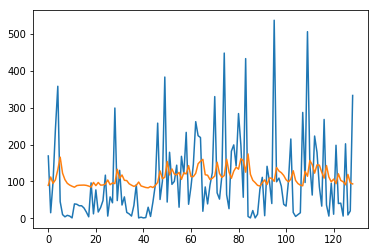

In [169]:
#line plot of observed vs predicted
pyplot.plot(X[500:])
pyplot.plot(predictions)
pyplot.show()